In [1]:
#import bibliotek
import pandas as pd
import numpy as np
import nltk
import re
import zipfile
from zipfile import *
from random import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#wczytanie danych
train = pd.read_csv('/content/drive/MyDrive/covid_chatbot/data/QQP/train.csv', low_memory=False)
who = pd.read_csv('/content/drive/MyDrive/covid_chatbot/data/WHO/WHO_QA_data.csv', low_memory=False)
print("Size of original QQP Training Data: {}".format(len(train)))
print("Size of original WHO Data: {}".format(len(who)))

Size of original QQP Training Data: 404290
Size of original WHO Data: 1279


# Przygotowanie danych

Filtacja danych z WHO pod  kątem covid

In [4]:
covid_words = ['coronavirus', 'covid']
covidQA_df = pd.DataFrame(columns=['question','answer'])

i = 0
for index, row in who.iterrows():
    text = row['question'] + row['answer']
    for w in covid_words:
        if w in text.lower():            
            covidQA_df.loc[i] = [row['question'], row['answer']]
            i += 1

print("COVID-19 Question and Answer Pairs from WHO")
covidQA_df.to_csv('/content/drive/MyDrive/covid_chatbot/data/WHO/covid19_QA_data.csv', encoding='utf-8')
covidQA_df

COVID-19 Question and Answer Pairs from WHO


,question,answer
0,How are COVID-19 and influenza viruses similar?,"Firstly, COVID-19 and influenza viruses have a..."
1,How are COVID-19 and influenza viruses different?,The speed of transmission is an important poin...
2,What medical interventions are available for C...,While there are a number of therapeutics curre...
3,How do we know that a vaccine is safe?,The most commonly used vaccines we have today ...
4,Are pregnant women at higher risk from COVID-19?,Research is currently underway to understand t...
...,...,...
110,I am a policy maker. What can I do to prevent ...,When making preparedness and response plans fo...
111,Has violence against women increased since the...,"Violence against women is highly prevalent, an..."
112,How does COVID-19 increase risks of violence f...,"Stress, the disruption of social and protectiv..."
113,Who is most vulnerable?,"Women who are displaced, who are migrants or r..."


Znajdujemy słowa pojawiające się najczęsciej

In [5]:
import nltk
nltk.download('stopwords')
from nltk import FreqDist

text = ""
for index, row in covidQA_df.iterrows():
    text += row['question']+ " " + row['answer']

#preprocessing
def clean_text(text): 
    # usuwamy znaki specjalne
    text = text.replace("\xa0"," ").replace("\n"," ").replace("\t"," ").replace('\\\'s','\'s')
    # usuwamy znaki interpunkcyjne
    text = text.replace(","," ").replace("."," ").replace("?"," ").replace("("," ").replace(")"," ").replace("–"," ")
    return text.split()

tokens = clean_text(text)
stopwords = set(nltk.corpus.stopwords.words('english')).union(["the"])

fdist = FreqDist(w.lower() for w in tokens if not w.lower() in stopwords)
freq_df = pd.DataFrame(fdist.items())
freq_df.columns = ['word', 'freq']
#filtruję wyniki wyszukiwania pod kątem częstotliwości występowania
freq_df = freq_df.sort_values(by=['freq'], ascending=False)
freq_df[:200]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,word,freq
0,covid-19,326
24,health,123
73,people,76
139,risk,74
141,women,60
...,...,...
310,recommendations,11
428,caused,11
334,high,11
743,ensuring,11


Przygotowanie zbioru QQP pod kątem covid

In [6]:
def filter_QQP_train(df):
    # określamy keywords
    kwlist = ['flu ','influenza','health','virus','disease','hiv','treatment','infect','malaria','patient','protect', 'prevent', 'symptom', 'pandemic', 'medicine', 'illness', 'mask', 'vaccine']
    i = 0
    filtered_df = pd.DataFrame(columns=['question1','question2','is_duplicate','kw'])
    for index, row in df.iterrows():
        try:
            s = row['question1'] + " " + row['question2']
            kw = [w for w in kwlist if w in s.lower()]
            if len(kw) >= 1:
                filtered_df.loc[i] = [row['question1'], row['question2'], row['is_duplicate'], kw]
                i += 1
        except:
            pass
    return filtered_df

filtered_train = filter_QQP_train(train)
filtered_train

,question1,question2,is_duplicate,kw
0,What are some tips on making it through the jo...,What are some tips on making it through the jo...,0,[medicine]
1,How do I prevent breast cancer?,Is breast cancer preventable?,0,[prevent]
2,Is 7 days too late for rabies vaccine after a ...,Can I take rabies injection after 1 day of dog...,0,[vaccine]
3,What would happen if you cover one of your eye...,What happens if eye medicine enters the eye?,0,[medicine]
4,Why are women who are on their periods are reg...,Why is it always expected that a woman should ...,0,[prevent]
...,...,...,...,...
8045,How emotionally selfish should a child be rega...,Family Relationships and Dynamics: How does a ...,0,[disease]
8046,Have psychotherapists ever applied themelves w...,Do therapists have therapists?,0,[patient]
8047,Could a President or a presidential candidate ...,What is the full story of Shiva since their bi...,0,[hiv]
8048,What should I say when someone is expressing c...,"What does it mean to be ""people smart""?",0,[health]


In [7]:
def plot_kw_freq(filtered, usage, label):
    filtered_label = filtered.loc[lambda filtered: filtered['is_duplicate'] == label]
    print("Size of filtered QQP {} Data with label {}: {}".format(usage, label, len(filtered_label)))
    d = {}
    for index, row in filtered_label.iterrows():
        kws = row['kw']
        for kw in kws:
            count = d.get(kw, 0)
            d[kw] = count + 1
    kw_freq = pd.DataFrame(d.items())
    kw_freq.columns = ['kw', 'count']
    kw_freq = kw_freq.sort_values('count', ascending=True)
    kw_freq.plot.barh(x='kw', y='count', figsize=(10,6), fontsize=12)
    return kw_freq.sort_values('count', ascending=False)

Size of filtered QQP Training Data with label 0: 5897
           kw  count
3      health   1869
9     patient    730
1     prevent    587
6     protect    540
0    medicine    405
8   treatment    360
11      virus    344
12        hiv    343
5     symptom    255
7     disease    242
10     infect    195
13    illness    136
14       mask    106
2     vaccine     46
15       flu      35
4     malaria      5
16   pandemic      2
17  influenza      1


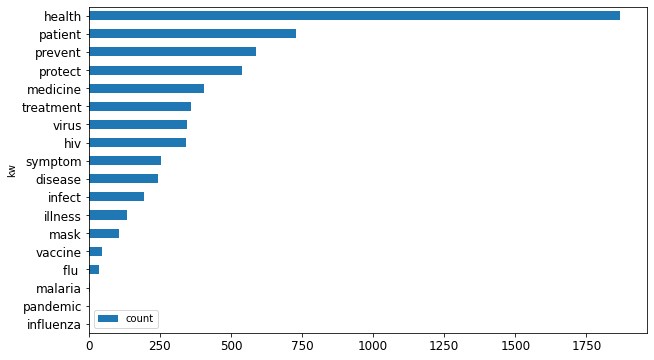

In [ ]:
print(plot_kw_freq(filtered_train, 'Training', 0))

Size of filtered QQP Training Data with label 1: 2153
           kw  count
2      health    857
1     prevent    306
3       virus    195
6   treatment    164
4     protect    153
5     symptom    140
10   medicine    115
9     disease    104
7         hiv     80
0     illness     53
8      infect     33
12    patient     26
11       mask     17
14    vaccine     15
15       flu       3
13   pandemic      1


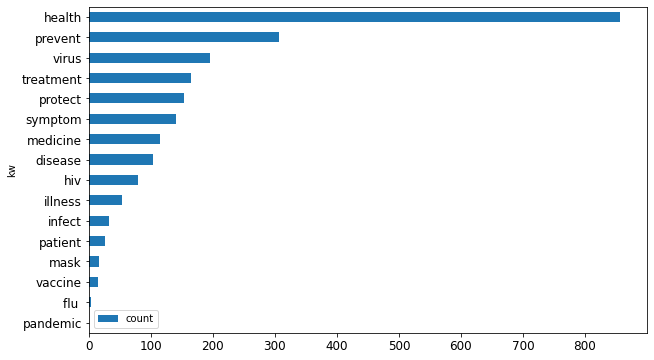

In [8]:
print(plot_kw_freq(filtered_train, 'Training', 1))

In [9]:
# zmniejszam rozmiar zbioru z etykietą 0
filtered_train0 = filtered_train.loc[lambda filtered_train: filtered_train['is_duplicate'] == 0]

i = 0
new_filtered_train0 = pd.DataFrame(columns=['question1','question2', 'is_duplicate','kw'])
for index, row in filtered_train0.iterrows():
    s = row['question1'] + " " + row['question2']
    decrease1 = ['health','patient','prevent','protect','medicine','treatment','hiv']
    decrease2 = ['virus','symptom','disease','infect']
    if len([w for w in decrease1 if w in s.lower()])>=1:
        if random() > 0.7:
            new_filtered_train0.loc[i] = [row['question1'],row['question2'],row['is_duplicate'],row['kw']]
            i += 1
    elif len([w for w in decrease2 if w in s.lower()])>=1:
        if random() > 0.5:
            new_filtered_train0.loc[i] = [row['question1'],row['question2'],row['is_duplicate'],row['kw']]
            i += 1 
    else:
        new_filtered_train0.loc[i] = [row['question1'],row['question2'],row['is_duplicate'],row['kw']]
        i += 1
            
new_filtered_train0   

,question1,question2,is_duplicate,kw
0,How do I prevent breast cancer?,Is breast cancer preventable?,0,[prevent]
1,Is 7 days too late for rabies vaccine after a ...,Can I take rabies injection after 1 day of dog...,0,[vaccine]
2,What would happen if you cover one of your eye...,What happens if eye medicine enters the eye?,0,[medicine]
3,My ex-girlfriend is suffering from malaria. I ...,Should I be worried that my girlfriend texts h...,0,[malaria]
4,How far would you go for love? Should I wait f...,"As a thirteen year old, what is the best thing...",0,[health]
...,...,...,...,...
2092,I had my wisdom teeth pulled years ago and dev...,"I have fat only in my torso, neck and face. Wh...",0,[symptom]
2093,How do I keep my boyfriend sexually satisfied?,Sexual Health: How do I approach and convince ...,0,[health]
2094,Is there really a health difference between Ma...,How much nicotine is in American Spirit cigare...,0,[health]
2095,Why are the main characters in One Piece calle...,Is it possible for psychopath to take off thei...,0,[mask]


In [10]:
# get filtered training data with label 1
filtered_train1 = filtered_train.loc[lambda filtered_train: filtered_train['is_duplicate'] == 1]
# combine filtered label 0 and label 1
training_data = pd.concat([new_filtered_train0, filtered_train1]).reset_index(drop=True)
training_data.to_csv('/content/drive/MyDrive/covid_chatbot/data/QQP/filteredQQP.csv', encoding='utf-8')
print("Size of filtered QQP Training Data with label 0: {}".format(len(new_filtered_train0)))
print("Size of filtered QQP Training Data with label 1: {}".format(len(filtered_train1)))
training_data

Size of filtered QQP Training Data with label 0: 2097
Size of filtered QQP Training Data with label 1: 2153


,question1,question2,is_duplicate,kw
0,How do I prevent breast cancer?,Is breast cancer preventable?,0,[prevent]
1,Is 7 days too late for rabies vaccine after a ...,Can I take rabies injection after 1 day of dog...,0,[vaccine]
2,What would happen if you cover one of your eye...,What happens if eye medicine enters the eye?,0,[medicine]
3,My ex-girlfriend is suffering from malaria. I ...,Should I be worried that my girlfriend texts h...,0,[malaria]
4,How far would you go for love? Should I wait f...,"As a thirteen year old, what is the best thing...",0,[health]
...,...,...,...,...
4245,What is health?,What is for health?,1,[health]
4246,What is indicative of someone with borderline ...,What are distinct symptoms of borderline perso...,1,[symptom]
4247,What could be the best possible diet plan for ...,What is a good diet plan for a commuter that w...,1,[health]
4248,How can I protect my PHP website from spam or ...,How do I protect my PHP website from hackers?,1,[protect]


Podział danych na zbiór treningowy i testowy

In [11]:
filtered_QQP0 = new_filtered_train0
filtered_QQP1 = filtered_train1

# split portion: 80% training data, 20% testing data
filtered_QQP_train0, filtered_QQP_test0 = train_test_split(filtered_QQP0, test_size=0.2, random_state=40)
filtered_QQP_train1, filtered_QQP_test1 = train_test_split(filtered_QQP1, test_size=0.2, random_state=40)

# combine label 0 and label 1
training_data = pd.concat([filtered_QQP_train0, filtered_QQP_train1]).reset_index(drop=True)
testing_data = pd.concat([filtered_QQP_test0, filtered_QQP_test1]).reset_index(drop=True)

# save to csv file
training_data.to_csv('/content/drive/MyDrive/covid_chatbot/data/training_data.csv', encoding='utf-8')
testing_data.to_csv('/content/drive/MyDrive/covid_chatbot/data/evaluation_data.csv', encoding='utf-8')

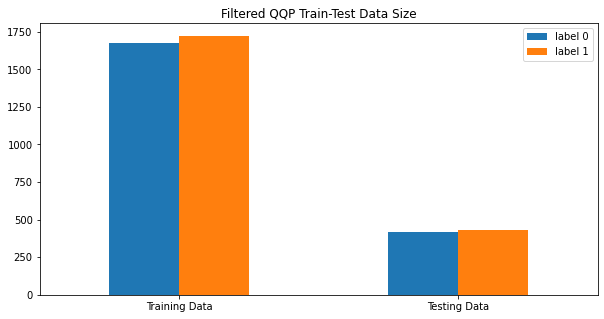

In [12]:
name_list=["Training Data","Testing Data"]

pair_list=[[len(filtered_QQP_train0),len(filtered_QQP_train1)],
           [len(filtered_QQP_test0),len(filtered_QQP_test1)]]

pair_list=np.array(pair_list)
img_df = pd.DataFrame(pair_list,index=name_list,columns=["label 0","label 1"])
img_df.plot(kind="bar",rot=0, figsize=(10, 5), title="Filtered QQP Train-Test Data Size")
plt.savefig("/content/drive/MyDrive/covid_chatbot/data/QQP/FilteredQQP_TrainTestDataSize.jpg")
plt.show()

# Wykorzystanie techniki uczenia maszynowego BERT (Bidirectional Encoder Representations from Transformers), opartej na transformatorach do wstępnego szkolenia w zakresie przetwarzania języka naturalnego (NLP)

In [13]:
!pip install sentence_transformers

     |████████████████████████████████| 78 kB 3.6 MB/s 
     |████████████████████████████████| 3.4 MB 32.9 MB/s 
     |████████████████████████████████| 6.8 MB 15.4 MB/s 
     |████████████████████████████████| 1.2 MB 39.9 MB/s 
     |████████████████████████████████| 67 kB 3.7 MB/s 
     |████████████████████████████████| 596 kB 44.8 MB/s 
     |████████████████████████████████| 895 kB 48.1 MB/s 
     |████████████████████████████████| 3.3 MB 37.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=120999 sha256=8a033a1ffcf7be51452655123a1db4131209a140364f187680893d7c03af99ac
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [14]:
#wczyatnie bibliotek
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses, util, evaluation,models
from torch.utils.data import DataLoader
import pandas as pd
import datetime

In [118]:
#ładujemy model
#model = SentenceTransformer('bert-base-nli-mean-tokens')
#model = SentenceTransformer('multi-qa-distilbert-cos-v1')
#model = SentenceTransformer('all-MiniLM-L6-v2')
model = SentenceTransformer('multi-qa-mpnet-base-cos-v1')

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Parametry treningu

In [119]:
# sciezki do danych
train_data_path = "/content/drive/MyDrive/covid_chatbot/data/training_data.csv"
eval_data_path = "/content/drive/MyDrive/covid_chatbot/data/evaluation_data.csv"

# ustawiamy parametry

epochs=3

# batch_size: [32,64,128]
batch_size = 16

# learning_rate: [2e-01, 2e-03, 2e-05, 2e-07]
learning_rate = 2e-10


# fixed
optimizer_eps = 2e-05
warmup_steps=100
evaluation_steps=500


# save model
new_model = "model_multi-qa-mpnet" + '-eps' + str(epochs) + '-batch' + str(batch_size) + '-lr' + str(learning_rate)
model_save_path = '/content/drive/MyDrive/covid_chatbot/' + new_model

Trening

In [120]:
train_df = pd.read_csv(train_data_path).loc[:, ['question1', 'question2', 'is_duplicate']].dropna()
train = train_df.apply(lambda row: InputExample(texts=[row[0], row[1]], label=float(row[2])), axis=1)
train_dataset = SentencesDataset(train, model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

Funkcja straty

In [121]:
train_loss = losses.CosineSimilarityLoss(model)

In [122]:
eval_df = pd.read_csv(eval_data_path).loc[:, ['question1', 'question2', 'is_duplicate']].dropna()
sentences1 = eval_df['question1'].tolist()
sentences2 = eval_df['question2'].tolist()
scores = [float(i) for i in eval_df['is_duplicate'].tolist()]

evaluator = evaluation.EmbeddingSimilarityEvaluator(sentences1, sentences2, scores)

model.fit(train_objectives=[(train_dataloader, train_loss)], 
          epochs=epochs,
          optimizer_params={'correct_bias': False, 
                            'eps': optimizer_eps,
                            'lr': learning_rate},
          warmup_steps=warmup_steps,
          evaluator=evaluator,
          evaluation_steps=evaluation_steps,
          # save model
          output_path=model_save_path
         )

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/213 [00:00<?, ?it/s]

Iteration:   0%|          | 0/213 [00:00<?, ?it/s]

Iteration:   0%|          | 0/213 [00:00<?, ?it/s]

Testujemy model

In [123]:
# wybór modelu
#model = SentenceTransformer('/content/drive/MyDrive/covid_chatbot/model_bert-eps3-batch16-lr2e-10')
#model = SentenceTransformer('/content/drive/MyDrive/covid_chatbot/model_distilbert-eps3-batch16-lr2e-10')
model = SentenceTransformer('/content/drive/MyDrive/covid_chatbot/model_multi-qa-mpnet-eps3-batch16-lr2e-10')

In [126]:
import csv
#zbior testowy
#covid19_QA_data - dane z WHO przefiltrowane pod kątem covidu
covid19_QA_data = csv.reader(open('/content/drive/MyDrive/covid_chatbot/data/WHO/covid19_QA_data.csv'))

WHO_covid19_QA = {}
for row in covid19_QA_data:
    question = row[1]
    WHO_covid19_QA[question] = row[2]
    
sentences1 = pd.read_csv('/content/drive/MyDrive/covid_chatbot/data/WHO/covid19_QA_data.csv')['question'].tolist()

In [127]:
def chatbot(user_query):
    

    sentences2 = [user_query] * len(sentences1)

    # words embeddings
    embeddings1 = model.encode(sentences1, convert_to_tensor=True)
    embeddings2 = model.encode(sentences2, convert_to_tensor=True)

    # liczymy podobieństwo cosinusowe, pomiędzy pytaniem zadanym przez użytkownika, 
    #a pytaniami ze zbioru WHO  
    cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)

    # Output Similarity Score
    df = pd.DataFrame(columns=['WHO Question','Similarity Score'])
    for i in range(len(sentences1)):
        df.loc[i] = [sentences1[i], cosine_scores[i][i].item()]
    
    cols = []
    vals = [[]]

    cols.append('User Question')
    vals[0].append(user_query)

    for i in range(0,len(df['WHO Question'])):
      cols.append(df['WHO Question'][i])
      vals[0].append(df['Similarity Score'].iloc[i])
    
    similarity = pd.DataFrame(vals, columns = cols)
    df = df.sort_values('Similarity Score', ascending=False)
    
    # Get Answer by mapping WHO_covid19_QA Dict
    q = df.iloc[0]['WHO Question']
    a = WHO_covid19_QA[q]
    top5 = df[:5]
    top = df.iloc[0]
    model_overview = pd.DataFrame([('model_multi-qa-mpnet', user_query, top['WHO Question'], top['Similarity Score'])], columns=['model', 'user_question', 'model_question', 'cosine_score'])
    return q, a, top5, similarity, model_overview

In [128]:
test_df = pd.read_csv('/content/drive/MyDrive/covid_chatbot/data/test_data.csv')
test_dict = {}
for index, row in test_df.iterrows():
    value = test_dict.get(row['user_query'], [])
    value.append(row['who_question'])
    test_dict[row['user_query']] = value

In [109]:
model_overview = pd.DataFrame()

In [129]:
test_queries = test_df["user_query"].unique()
n = len(test_queries)

match = 0
graph = pd.DataFrame()
for test_query in test_queries:
    print("User Query: {}".format(test_query))
    expected_who_questions = test_dict[test_query]
    question_by_model, answer_by_model, top5_qa_by_model, similarity, overview = chatbot(test_query)
    print("WHO Question Selected by Chatbot: {}".format(question_by_model))
    graph = graph.append(similarity, ignore_index=True)
    model_overview = model_overview.append(overview, ignore_index=True)
    if question_by_model in expected_who_questions:
        match += 1
        print("No. {} / {} : MATCH".format(test_queries.tolist().index(test_query), n))
    else:
        print("No. {} / {} : FAIL".format(test_queries.tolist().index(test_query), n))


print("Model Matches: {} / {}".format(match, n))
print("Model Accuracy: {}".format(match/n))

User Query: Is coronavirus the flu?
WHO Question Selected by Chatbot: What is a coronavirus?
No. 0 / 21 : FAIL
User Query: Are there medicines to treat the coronavirus infection?
WHO Question Selected by Chatbot: Are there any medicines or therapies that can prevent or cure COVID-19?
No. 1 / 21 : FAIL
User Query: What is coronavirus?
WHO Question Selected by Chatbot: What is a coronavirus?
No. 2 / 21 : MATCH
User Query: Which foods boost immunity to viruses such as COVID-19?
WHO Question Selected by Chatbot: How to wash fruits and vegetables in the time of COVID-19?
No. 3 / 21 : FAIL
User Query: Is it true that COVID-19 does not spread through the air?
WHO Question Selected by Chatbot: Is COVID-19 airborne?
No. 4 / 21 : MATCH
User Query: Why is no one able to find medicine for Covid 19?
WHO Question Selected by Chatbot: Is there a vaccine, drug or treatment for COVID-19?
No. 5 / 21 : FAIL
User Query: Is social distancing helpful during the COVID-19 infection worldwide?
WHO Question Sel

#Wizualizacja wyników dla wybranych modeli

In [266]:
# zestawienie pytań użytkownika z wybranymi pytaniami przez poszczególne modele na podstawie najwyższej wartości podobieństwa cosinusowego
model_overview

,model,user_question,model_question,cosine_score
0,bert_base_nli_mean_tokens,Is coronavirus the flu?,What is a coronavirus?,0.825490
1,bert_base_nli_mean_tokens,Are there medicines to treat the coronavirus i...,Can antiretrovirals be used to prevent COVID-1...,0.845775
2,bert_base_nli_mean_tokens,What is coronavirus?,What is a coronavirus?,0.989411
3,bert_base_nli_mean_tokens,Which foods boost immunity to viruses such as ...,Can antiretrovirals be used to prevent COVID-1...,0.751809
4,bert_base_nli_mean_tokens,Is it true that COVID-19 does not spread throu...,Is there anything I should not do?,0.673832
...,...,...,...,...
58,model_multi-qa-mpnet,What is a novel coronavirus? What is the COVID...,What is a coronavirus?,0.781795
59,model_multi-qa-mpnet,Will Remdesivir be the cure for the coronaviru...,"Is there a vaccine, drug or treatment for COVI...",0.714260
60,model_multi-qa-mpnet,Can vaccines be effective in fighting COVID-19?,"Is there a vaccine, drug or treatment for COVI...",0.864983
61,model_multi-qa-mpnet,How soon could there be a cure for the COVID-1...,"Is there a vaccine, drug or treatment for COVI...",0.776476


In [263]:
question = pd.DataFrame()
for i in range(0, 21):
  question = question.append(model_overview.loc[model_overview['user_question'] == model_overview['user_question'].iloc[i]], ignore_index=True)


array = [[]for i in range(21)]
unique_q = pd.unique(question['user_question'])

for i in range(0,21):
  array[i].append(unique_q[i])
  uniqe_score_model = question.loc[question['user_question'] == unique_q[i]]
  for j in range(0,3):
    array[i].append(uniqe_score_model['cosine_score'].iloc[j])

a = pd.DataFrame(array, columns=['user_question', 'model_bert_base_nli_mean_tokens', 'model_distilbert', 'model_multi-qa-mpnet'])

In [264]:
a

,user_question,model_bert_base_nli_mean_tokens,model_distilbert,model_multi-qa-mpnet
0,Is coronavirus the flu?,0.825490,0.747898,0.784374
1,Are there medicines to treat the coronavirus i...,0.845775,0.706430,0.780176
2,What is coronavirus?,0.989411,0.989184,0.992409
3,Which foods boost immunity to viruses such as ...,0.751809,0.598734,0.625064
4,Is it true that COVID-19 does not spread throu...,0.673832,0.796876,0.846160
5,Why is no one able to find medicine for Covid 19?,0.693520,0.648389,0.737915
6,Is social distancing helpful during the COVID-...,0.763397,0.617700,0.666863
7,Is coronavirus a virus or a bacteria?,0.812731,0.828095,0.827382
8,Is there a vaccine for the coronavirus?,0.852911,0.757556,0.761826
9,What are the symptoms of COVID-19?,0.999999,1.000000,1.000000


Wykresy

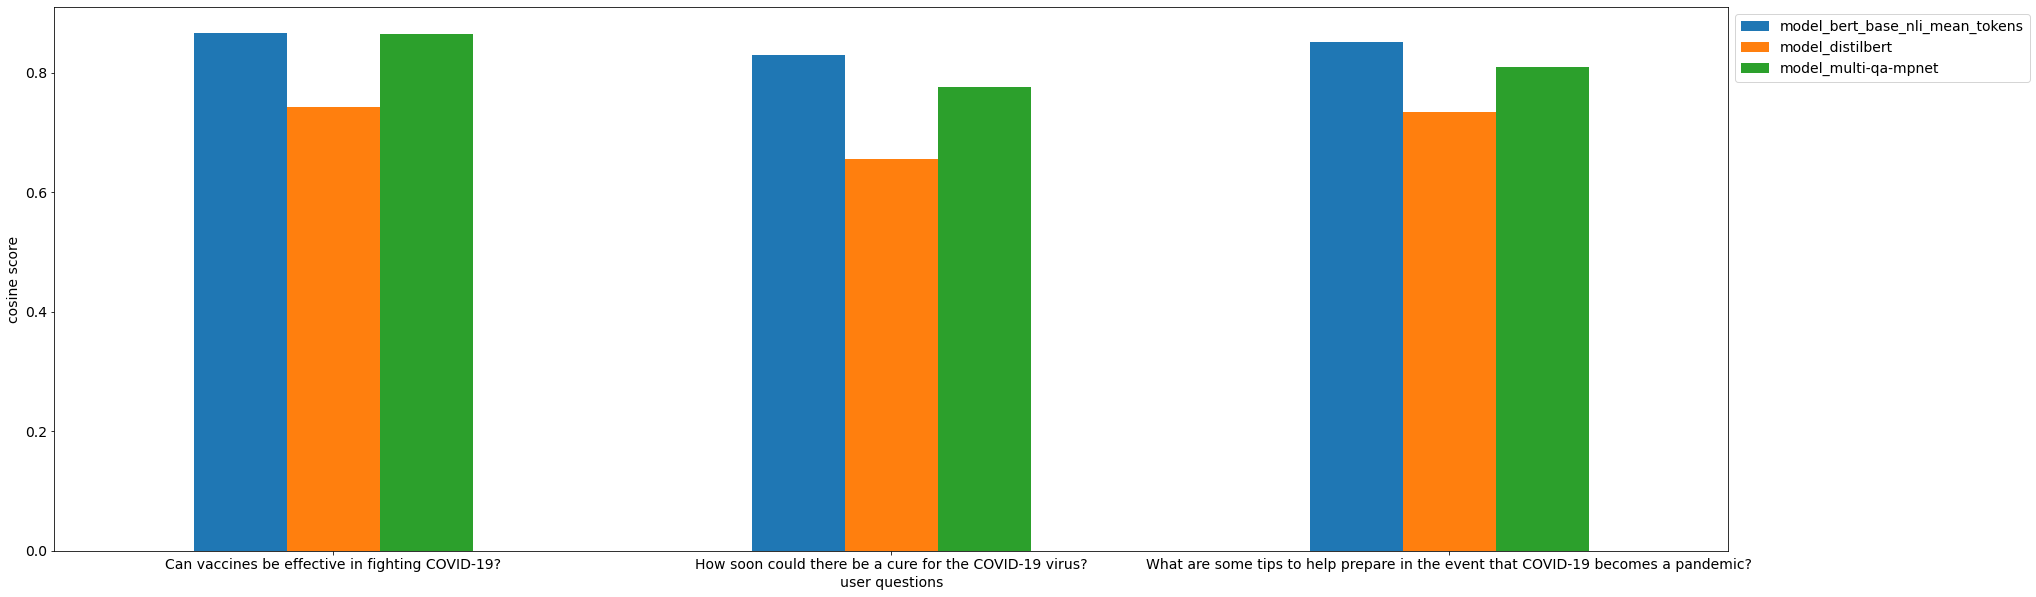

In [265]:
b = a.iloc[18:21,:]
p = b.plot(kind="bar", figsize=(30,10), fontsize=14)
p.set_ylabel('cosine score', fontsize=14)
p.set_xlabel('user questions', fontsize=14)
p.legend(bbox_to_anchor=(1.0, 1.0), fontsize=14)
p = p.set_xticklabels(b['user_question'], rotation=0)

#Demonstracja działania

In [ ]:
user_query = " Are there any medicines or therapies that can prevent or cure COVID-19?"
q, a, top5 = chatbot(user_query)

print("Query: {}".format(user_query))
print("Chatbot Answer: {}".format(a))

Query:  Are there any medicines or therapies that can prevent or cure COVID-19?
Chatbot Answer: While some western, traditional or home remedies may provide comfort and alleviate symptoms of COVID-19, there is no evidence that current medicine can prevent or cure the disease. WHO does not recommend self-medication with any medicines, including antibiotics, as a prevention or cure for COVID-19. However, there are several ongoing clinical trials that include both western and traditional medicines. WHO will continue to provide updated information as soon as clinical findings are available.
